In [6]:
### Imports and reading data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
ROOT = Path(r"C:\Users\moein\anaconda3\citi-bike-2022-weather")
PROC = ROOT / "data" / "processed"

daily_path = PROC / "citibike_2022_daily_with_weather.csv"
trips_path = PROC / "citibike_2022_all.csv"

# Load daily data
daily = pd.read_csv(daily_path)
daily.columns = [c.strip().lower() for c in daily.columns]
daily["date"] = pd.to_datetime(daily["date"])
daily = daily[daily["date"].dt.year == 2022].sort_values("date").reset_index(drop=True)

# Load trips data
trips = pd.read_csv(trips_path, low_memory=False)
trips.columns = [c.strip().lower() for c in trips.columns]

# Compute ride length if missing
if "ride_length_min" not in trips.columns:
    s = pd.to_datetime(trips["started_at"], errors="coerce")
    e = pd.to_datetime(trips["ended_at"], errors="coerce")
    trips["ride_length_min"] = (e - s).dt.total_seconds() / 60.0

daily.head()

,date,rides,member_share,avg_temp_c
0,2022-01-01,592,0.543919,11.6
1,2022-01-02,1248,0.584936,11.4
2,2022-01-03,832,0.772837,1.4
3,2022-01-04,934,0.776231,-2.7
4,2022-01-05,914,0.750547,3.2


In [3]:
### Pick a global theme (style + palette)

sns.set_theme(style="whitegrid", palette="deep")

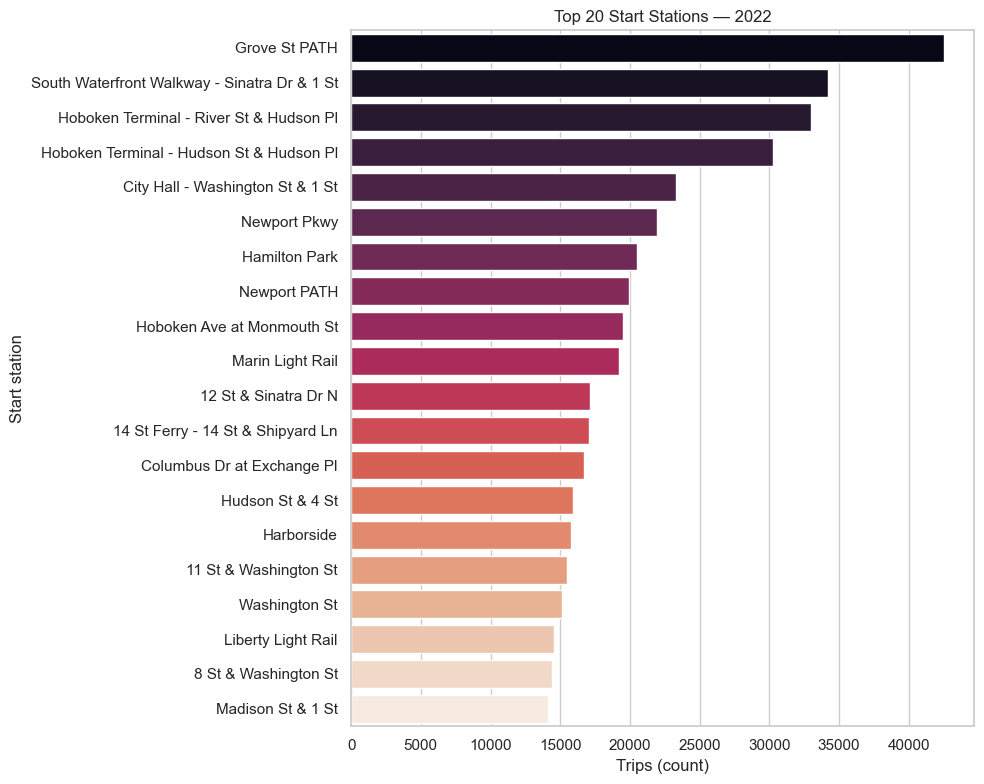

In [4]:
### Bar chart — Top 20 starting stations

start_station_col = "start_station_name" if "start_station_name" in trips.columns else "from_station_name"

top20 = (
    trips.dropna(subset=[start_station_col])
         .groupby(start_station_col)
         .size()
         .rename("value")
         .reset_index()
         .sort_values("value", ascending=False)
         .head(20)
)

top20 = top20.copy()
top20["rank"] = range(len(top20))  # create a categorical rank

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=top20, 
    x="value", 
    y=start_station_col, 
    orient="h", 
    hue="rank", 
    dodge=False, 
    palette="rocket"
)
ax.get_legend().remove()
ax.set_title("Top 20 Start Stations — 2022")
ax.set_xlabel("Trips (count)")
ax.set_ylabel("Start station")
plt.tight_layout()
plt.show()

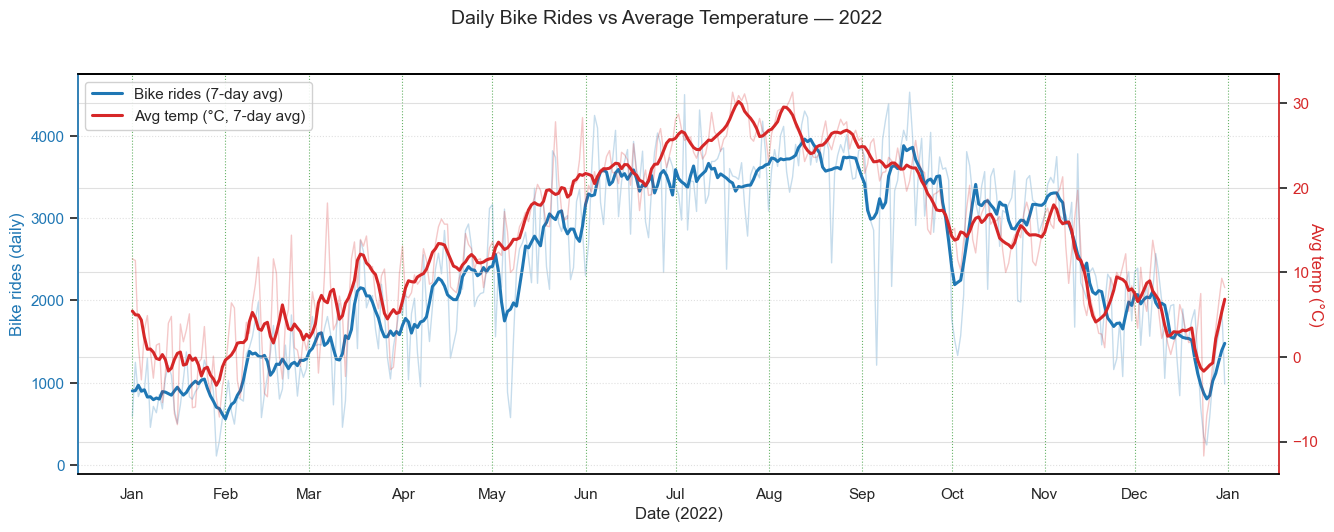

In [37]:
### Dual-axis line chart — Bike rides vs. temperature

import matplotlib.dates as mdates

ROLL = 7
rides_color = "tab:blue"
temp_color  = "tab:red"

daily = daily.sort_values("date").copy()
daily["date"] = pd.to_datetime(daily["date"], errors="coerce")
daily["rides_roll"] = daily["rides"].rolling(ROLL, min_periods=1, center=True).mean()
daily["temp_roll"]  = daily["avg_temp_c"].rolling(ROLL,  min_periods=1, center=True).mean()

fig, ax = plt.subplots(figsize=(13.5,5.2))

ax.grid(True, axis="x", linestyle=":", color="green", linewidth=0.8, alpha=0.6)
ax.grid(True, axis="y", linestyle=":", linewidth=0.8, alpha=0.6)

# Left axis: rides
sns.lineplot(data=daily, x="date", y="rides", ax=ax,
             color=rides_color, alpha=0.25, linewidth=1,
             legend=False)
sns.lineplot(data=daily, x="date", y="rides_roll", ax=ax,
             color=rides_color, linewidth=2.2,
             label="Bike rides (7-day avg)", legend=False)

ax.set_xlabel("Date (2022)")
ax.set_ylabel("Bike rides (daily)", color=rides_color)
ax.tick_params(axis="y", labelcolor=rides_color)

# Right axis: temperature
ax2 = ax.twinx()
sns.lineplot(data=daily, x="date", y="avg_temp_c", ax=ax2,
             color=temp_color, alpha=0.25, linewidth=1,
             legend=False)
sns.lineplot(data=daily, x="date", y="temp_roll", ax=ax2,
             color=temp_color, linewidth=2.2,
             label="Avg temp (°C, 7-day avg)", legend=False)

ax2.set_ylabel("Avg temp (°C)", color=temp_color, rotation=-90)
ax2.tick_params(axis="y", labelcolor=temp_color)
ax2.grid(True, axis="y", linestyle="-", linewidth=0.8, alpha=0.6)

# Formatting
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

ax2.spines["left"].set_color(rides_color)
ax2.spines["right"].set_color(temp_color)
ax2.spines["bottom"].set_color("black")
ax.spines["top"].set_color("black")
ax2.spines["top"].set_color("black")

# Only one combined legend, upper left
lines = [ax.lines[-1], ax2.lines[-1]]
labels = [ln.get_label() for ln in lines]
leg = ax.legend(lines, labels, loc="upper left", frameon=True)
leg.get_frame().set_alpha(0.9)

fig.suptitle("Daily Bike Rides vs Average Temperature — 2022", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

#### Dual-Axis Line Chart — Daily Bike Rides vs. Average Temperature

In this chart, I used seaborn and matplotlib to visualize the relationship between bike usage and average daily temperature throughout 2022. The plot uses a dual-axis design: the left y-axis (blue) shows the number of daily bike rides, while the right y-axis (red) shows the average temperature in degrees Celsius. To reduce noise and highlight overall patterns, I included both faint daily values and bold 7-day rolling averages for each variable. This makes it easier to identify clear seasonal trends while still keeping the daily variation visible in the background.

To improve readability, the y-axis labels and spines are color-coded to match their respective data series (blue for rides, red for temperature). Monthly ticks were added to the x-axis for clearer time progression, and gridlines are kept subtle to avoid distraction. Seaborn’s default legends were disabled, and instead a single combined legend was created manually and placed in the upper-left corner. This prevents duplicate legends and keeps the visualization clean.

The plot shows a clear seasonal relationship: bike rides increase steadily with rising spring temperatures, peak in the summer months when the weather is warmest, and then decline again during fall and winter. Despite fluctuations, the close alignment between the red (temperature) and blue (rides) trends suggests that temperature is a strong driver of bike usage. This type of visualization provides valuable insights for urban planners, transportation analysts, and policymakers when considering how seasonal weather patterns influence ridership levels.

C:\Users\moein\AppData\Local\Temp\ipykernel_5608\184901857.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


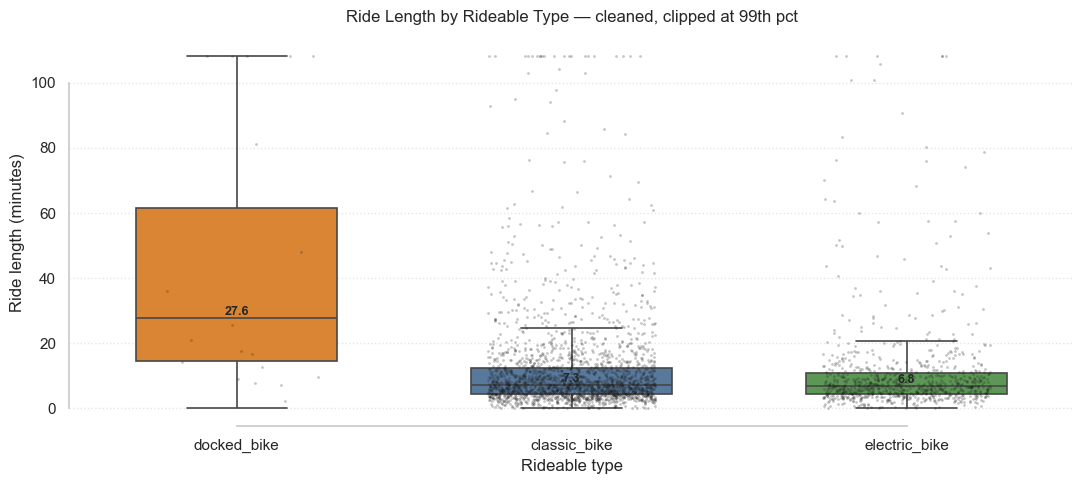

In [38]:
### Box plot — Ride length by rideable type

# --- polish parameters you can tweak ---
PALETTE = {"classic_bike": "#4C78A8", "docked_bike": "#F58518", "electric_bike": "#54A24B"}
SHOW_POINTS = True         # overlay a light jittered sample
POINT_SAMPLE = 3000        # limit points for speed/clarity
USE_LOG_Y = False          # set True if tails still dominate

# 1) Clean & prep
df_box = trips[["rideable_type", "ride_length_min"]].dropna().copy()

# Remove impossible negatives (data quality)
df_box = df_box[df_box["ride_length_min"] >= 0]

# Clip extreme upper tail for readability
p99 = df_box["ride_length_min"].quantile(0.99)
df_box["ride_length_min_clip"] = df_box["ride_length_min"].clip(upper=p99)

# 2) Order categories by median duration (descending)
med = (df_box.groupby("rideable_type")["ride_length_min_clip"]
              .median()
              .sort_values(ascending=False))
order = med.index.tolist()

# 3) Plot
plt.figure(figsize=(11,5))
ax = sns.boxplot(
    data=df_box, x="rideable_type", y="ride_length_min_clip",
    order=order, palette=[PALETTE.get(k, "#7f7f7f") for k in order],
    width=0.6, linewidth=1.2, showfliers=False
)

# Overlay a light jittered sample of points for distribution feel
if SHOW_POINTS:
    pts = (df_box.sample(n=min(POINT_SAMPLE, len(df_box)), random_state=42)
                 .assign(_x=lambda d: pd.Categorical(d["rideable_type"], categories=order, ordered=True)))
    sns.stripplot(
        data=pts, x="_x", y="ride_length_min_clip",
        order=order, color="k", alpha=0.25, jitter=0.25, size=2, ax=ax
    )

# 4) Median annotations
for i, cat in enumerate(order):
    m = med.loc[cat]
    ax.text(i, m, f"{m:.1f}", ha="center", va="bottom", fontsize=9, fontweight="bold")

# 5) Labels, tick formatting, optional log scale
ax.set_title("Ride Length by Rideable Type — cleaned, clipped at 99th pct", pad=12)
ax.set_xlabel("Rideable type")
ax.set_ylabel("Ride length (minutes)")
if USE_LOG_Y:
    ax.set_yscale("log")
    ax.set_ylabel("Ride length (minutes, log scale)")

# 6) Minor styling
sns.despine(trim=True)
ax.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

#### Box Plot Analysis — Ride Length by Rideable Type

This box plot shows the distribution of ride lengths across the three bike types. Docked bikes have the longest rides on average, with a median of around 27 minutes and a much wider interquartile range, suggesting they are often used for longer or occasional trips. Classic and electric bikes have shorter and more consistent ride lengths, with medians of about 7 minutes, indicating they are typically used for quick, routine trips. The presence of outliers in all categories highlights that some rides are unusually long, but these are rare compared to the main distribution. Overall, the variable reveals clear differences in how each bike type is used by riders.

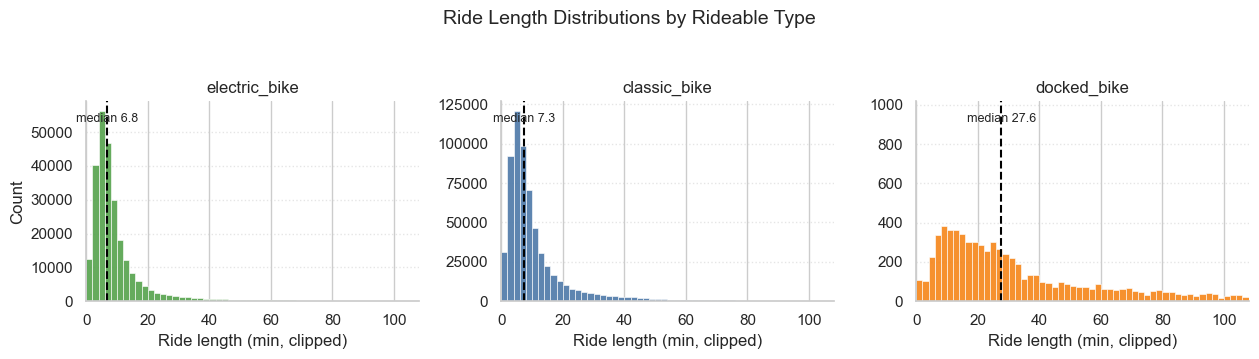

In [39]:
### FacetGrid — Ride length distributions

# Clean + prep (keep only non-negative, already clipped values)
fh = df_box[df_box["ride_length_min_clip"] >= 0].copy()

# Order facets by median ride length (ascending)
order = (fh.groupby("rideable_type")["ride_length_min_clip"]
           .median()
           .sort_values()
           ).index.tolist()

# Consistent palette per type
palette = {"classic_bike": "#4C78A8", "docked_bike": "#F58518", "electric_bike": "#54A24B"}

# Common binning & x-limit across facets (improves comparability)
xmax = float(fh["ride_length_min_clip"].quantile(0.995))
bins = np.arange(0, xmax + 2, 2)   # 2-minute bins

# Allow each facet its own y-axis scaling
g = sns.FacetGrid(
    fh, col="rideable_type", col_order=order,
    sharex=True, sharey=False, height=3.4, aspect=1.25, despine=True
)

def facet_hist(data, color=None, **kws):
    typ = data["rideable_type"].iat[0]
    c = palette.get(typ, color)
    # Histogram (counts), solid fill
    sns.histplot(data=data, x="ride_length_min_clip", bins=bins,
                 color=c, alpha=0.9, edgecolor=None, **kws)
    # Median line + label
    m = data["ride_length_min_clip"].median()
    ax = plt.gca()
    ax.axvline(m, ls="--", lw=1.5, color="black")
    ax.text(m, ax.get_ylim()[1]*0.94, f"median {m:.1f}",
            ha="center", va="top", fontsize=9)

g.map_dataframe(facet_hist)

g.map(sns.histplot, "ride_length_min_clip", bins=bins, stat="density")

# Axes formatting
g.set_axis_labels("Ride length (min, clipped)", "Count")
g.set_titles(col_template="{col_name}")
for ax in g.axes.flatten():
    ax.grid(axis="y", linestyle=":", alpha=0.5)
    ax.set_xlim(0, xmax)

g.fig.suptitle("Ride Length Distributions by Rideable Type", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

### FacetGrid Analysis — Ride Length Distributions

The FacetGrid visualization highlights clear differences in ride length distributions across bike types. Both **classic_bike** and **electric_bike** trips cluster tightly around short durations (~7 minutes), while **docked_bike** trips are much longer on average, with a median near 28 minutes. This suggests docked bikes are used for distinct, longer trips, whereas classic and electric bikes serve quick, short-distance rides.